The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Speciﬁcally, the problems of:

* Activity Recognition: generating a textual description of an activity demonstrated in a sequence of images
* Image Description: generating a textual description of a single image
* Video Description: generating a textual description of a sequence of images

This architecture is used for the task of generating textual descriptions of images. Key is the use of a CNN that is pre-trained on a challenging image classiﬁcation task that is re-purposed as a feature extractor for the caption generating problem.

This architecture has also been used on speech recognition and natural language processing problems where CNNs are used as feature extractors for the LSTMs on audio and textual input data. This architecture is suitable for problems that:

* Have spatial structure in their input such as the 2D structure or pixels in an image or the 1D structure of words in a sentence, paragraph, or document.
* Have a temporal structure in their input such as the order of images in a video or words in text, or require the generation of output with temporal structure such as words in a textual description.

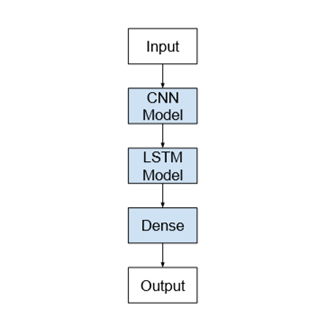

In [1]:
from IPython.display import Image
Image('C:/Users/Manoj/Desktop/Images/cnn lstm.png')

We can deﬁne a CNN LSTM model to be trained jointly in Keras. A CNN LSTM can be deﬁned by adding CNN layers on the front end followed by LSTM layers with a Dense layer on the output.

It is helpful to think of this architecture as deﬁning two sub-models: the CNN Model for feature extraction and the LSTM Model for interpreting the features across time steps.

Let’s take a look at both of these sub models in the context of a sequence of 2D inputs which are images.

#CNN Model

We can deﬁne a 2D convolutional network as comprised of Conv2D and MaxPooling2D layers ordered into a stack of the required depth.

#LSTM

The CNN model above is only capable of handling a single image, transforming it from input pixels into an internal matrix or vector representation. 

We need to repeat this operation across multiple images and allow the LSTM to build up internal state and update weights using BPTT across a sequence of the internal vector representations of input images.

The CNN could be ﬁxed in the case of using an existing pre-trained model like VGG for feature extraction from images. The CNN may not be trained, and we may wish to train it by backpropagating error from the LSTM across multiple input images to the CNN model.

In both of these cases, conceptually there is a single CNN model and a sequence of LSTM models, one for each time step. We want to apply the CNN model to each input image and pass on the output of each input image to the LSTM as a single time step.

It can be achieved by wrapping the entire CNN input model (one layer or more) in a **TimeDistributed** layer. This layer achieves the desired outcome of applying the same layer or layers multiple times. In this case, applying it multiple times to multiple input time steps and in turn providing a sequence of image interpretations or image features to the LSTM model to work on.

#### Moving Square Video Prediction Problem

The moving square video prediction problem is used here to demonstrate CNN LSTM architecture. The problem involves the generation of a sequence of frames. In each image a line is drawn from left to right or right to left. Each frame shows the extension of the line by one pixel.

The task is for the model to classify whether the line moved left or right in the sequence of frames. Technically, the problem is a sequence classiﬁcation problem framed with a many-to-one prediction model.

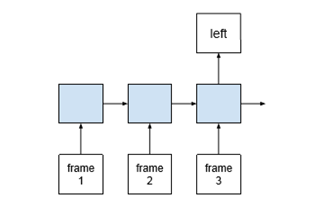

In [2]:
Image('C:/Users/Manoj/Desktop/Images/cnn lstm1.png')

The entire problem can be broken down into 3 steps:

1. Image Initialization
2. Adding steps
3. Instance generator

##### Image Initialization

We can start by deﬁning a 2D NumPy array ﬁlled with zero values. We will make the images symmetrical, and in this case, 10 pixels by 10 pixels.

In [3]:
import numpy as np
frame = np.zeros((10,10))
frame

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Next, we can select the row for the ﬁrst step of the line. We will use the randint() function to select a uniformly random integer between 0 and 9.

In [4]:
from random import randint
step = randint(0, 10-1)
step

3

We can now select whether we are drawing the line left or right across the image. We will use the random() function to decide. If right, we will start at the left, or column 0, and if left we will start on the right, or column 9.

In [5]:
from random import random
right = 1 if random() < 0.5 else 0
col = 0 if right else size-1

We can now mark the start of the line

In [6]:
frame[step, col] = 1
frame

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

#### Adding steps

Now we need a process to add steps to the line. The next step must be a function of the previous step. We will constrain it to be in the next column along (left or right) and be in the same row, the row above or the row below.

We will further constrain the movement by the bounds of the image, e.g. no movements below row zero or above row 9.

We can use the same randint() function above to pick the next step and impose our movement constraints on the upper and lower values. The step value chosen last time is stored in the last_step variable.

In [22]:
#lower = max(0, last_step-1) 
#upper = min(10-1, last_step+1) 
#step = randint(lower, upper)

Next, we can make a copy of the last image and mark the new position for the next column along.

In [23]:
#column = i if right else size-1-i 
#frame = last_frame.copy() 
#frame[step, column] = 1

This process can be repeated until the ﬁrst or last column is reached, depending on the chosen direction

##### Instance Generator

We can capture all of the above behavior in two small functions. The build_frames() function takes an argument to deﬁne the size of the images and returns a sequence of images and whether the line moves right (1) or left (0).

This function calls another function next_frame() to create each subsequent frame after the ﬁrst frame as the line moves across the image.

In [14]:
from random import random, randint
from numpy import array, zeros
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
    # define the scope of the next step
    lower = max(0, last_step-1)
    upper = min(last_frame.shape[0]-1, last_step+1)
    # choose the row index for the next step
    step = randint(lower, upper)
    # copy the prior frame
    frame = last_frame.copy()
    # add the new step
    frame[step, column] = 1
    return frame, step

In [10]:
# generate a sequence of frames of a dot moving across an image
def build_frames(size):
    frames = list()
    # create the first frame
    frame = zeros((size,size))
    step = randint(0, size-1)
    # decide if we are heading left or right
    right = 1 if random() < 0.5 else 0
    col = 0 if right else size-1
    frame[step, col] = 1
    frames.append(frame)
    # create all remaining frames
    for i in range(1, size):
        col = i if right else size-1-i
        frame, step = next_frame(step, frame, col)
        frames.append(frame)
    return frames, right

We will generate a small sequence with each image 5x5 pixels and with 5 frames and plot the frames side by side

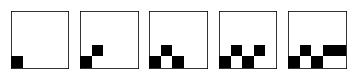

In [21]:
# generate sequence of frames
size = 5 
frames, right = build_frames(size)
# plot all frames 
plt.figure() 
for i in range(size):
    # create a grayscale subplot for each frame 
    plt.subplot(1, size, i+1)
    plt.imshow(frames[i], cmap= 'Greys')
    # turn of the scale to make it cleaer 
    ax = plt.gca()
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 
plt.show()

#### Prepare Input For Model

We will prepare a function to generate multiple sequences with the correct shape ready for ﬁtting and evaluating an LSTM model. A function named generate_examples() is deﬁned below that takes the size of the images to generate and the number of sequences to generate as arguments.

Each sequence is generated and stored. The input sequences for the model must be resized to be suitable for a 2D CNN. Normally this would be:

[width, height, channel]

In our case, it would be [size, size, 1] for the symmetrical black and white images. This is not sufficient as we also have multiple images, then multiple sequences of images. Therefore, the input to the model must be reshaped as:

[samples, timesteps, width, height, channels]

Or

[n_patterns, size, size, size, 1]

In [11]:
# generate multiple sequences of frames and reshape for network input
def generate_examples(size, n_patterns): 
    X, y = list(), list()
    for _ in range(n_patterns):
        frames, right = build_frames(size)
        X.append(frames)
        y.append(right)
    # resize as [samples, timesteps, width, height, channels]
    X = array(X).reshape(n_patterns, size, size, size, 1)
    y = array(y).reshape(n_patterns, 1)
    return X, y

#### Define and Compile Model

Next, We deﬁne a CNN LSTM to ﬁt the model. The size of the generated images controls how challenging the problem will be. We will make the problems modestly challenging by conﬁguring the images to be 50x50 pixels, or a total of 2,500 binary values.

We will deﬁne the model wrapping each layer in the CNN model with a separate TimeDistributed layer. This is to ensure that the model summary provides a clear idea of how the network hangs together.

We will deﬁne a Conv2D as an input layer with 2 ﬁlters and a 2x2 kernel to pass across the input images. The Conv2D will output 2 49x49 pixel impressions of the input.

Here we use a MaxPooling2D pooling layer with a pool size of 2x2, which will in effect halve the size of each ﬁlter output from the previous layer, in turn outputting 2 24x24 maps.

The pooling layer is followed by a Flatten layer to transform the [24,24,2] 3D output from the MaxPooling2D layer into a one-dimensional 1,152 element vector.

The CNN model is a feature extraction model. The hope is that the vector output of the Flatten layer is a compressed and/or more salient representation of the image than the raw pixel values.

Next, we can deﬁne the LSTM elements of the model. We will use a single LSTM layer with 50 memory cells.

The use of a TimeDistribted wrapper around the whole CNN model means that the LSTM will see 50 time steps, with each time step presenting a 1,152 element vector as input.

This is a binary classiﬁcation problem, so we will use a Dense output with a single neuron and the sigmoid activation function. The model is compiled to minimize log loss (binary_crossentropy) with the Adam implementation of gradient descent and the binary classiﬁcation accuracy will be reported.

In [26]:
size = 50

# define the model 
model = Sequential()
model.add(TimeDistributed(Conv2D(2, (2,2), activation= 'relu'), input_shape=(None,size,size,1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)))) 
model.add(TimeDistributed(Flatten())) 
model.add(LSTM(50)) 
model.add(Dense(1, activation= 'sigmoid')) 
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['acc']) 
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, None, 49, 49, 2)   10        
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 24, 24, 2)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 1152)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                240600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 240,661
Trainable params: 240,661
Non-trainable params: 0
_________________________________________________________________
None


#### Fit the Model

Now we ﬁt the model on randomly generated examples of the problem. The generate_examples() function deﬁned above will prepare a speciﬁed number of random sequences that we can keep in memory and use to ﬁt the model efficiently.

The number of randomly generated examples is a proxy for the number of training epochs as we would prefer the model to be trained on unique problem instances rather than the same set of random instances again and again.

Here we will train the model on a single epoch of 5,000 randomly generated sequences. Ideally, the internal state of the LSTM would be reset at the end of each sequence. We could achieve this by setting the batch size to 1. We will trade off the quality of the model for computational efficiency and set the batch size to 32.

In [27]:
#fit the model
X,y = generate_examples(size, 5000)
model.fit(X, y, batch_size=32, epochs = 1)

Epoch 1/1
5000/5000 [==============================] - 710s 142ms/step - loss: 0.1545 - acc: 0.9258


#### Evaluate the Model

Next, we can estimate the skill of the model on new random sequences. Here, we can generate 100 new random sequences and evaluate the accuracy of the model.

In [28]:
# evaluate model 
X, y = generate_examples(size, 100) 
loss, acc = model.evaluate(X, y, verbose=0) 
print('loss: %f, acc: %f' % (loss, acc*100))

loss: 0.006691, acc: 100.000000


#### Make Prediction

In [29]:
# prediction on new data 
X, y = generate_examples(size, 1) 
yhat = model.predict_classes(X, verbose=0) 
expected = 'Right' if y[0]==1 else 'Left' 
predicted = 'Right' if yhat[0]==1 else 'Left'
print('Expected: %s, Predicted: %s' % (expected, predicted))

Expected: Left, Predicted: Left
